In [ ]:
!pip install transformers
!pip install tensorflow
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from tensorflow.keras.utils import pad_sequences

import transformers as ppb
from transformers import (
    BertTokenizerFast,
    BertForMaskedLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW

from datasets import load_dataset

import warnings
# warnings.filterwarnings('ignore')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch

print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT tokenizer and masked-LM model
from transformers import BertTokenizerFast, BertForMaskedLM

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")
model.to(device)

special_tokens = {
    "additional_special_tokens": [
        "<TEXT>", "</TEXT>", "<CODE>", "<CODE/>"
    ]
}
tokenizer.add_special_tokens(special_tokens)
model.resize_token_embeddings(len(tokenizer))

print("BERT tokenizer and MLM model loaded successfully!")
print(f"Model is on device: {device}")

CUDA Available: True
GPU: Tesla T4


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT tokenizer and MLM model loaded successfully!
Model is on device: cuda


In [ ]:
import json
import random

random.seed(2025)

# 50,000 lines were chosen for training. We use the random seed of 2025 to deterministically grab the same random set.
k = 50000
sampled = []
with open("supercollider_dataset_tagged.jsonl", "r") as f:
    for i, line in enumerate(f):
        record = json.loads(line)
        if i < k:
            sampled.append(record)
        else:
            j = random.randint(0, i)
            if j < k:
                sampled[j] = record

df = pd.DataFrame(sampled)
print(f"Sampled {len(df)} examples")
display(df.sample(5))

# The datasets were made with 128 tokens in mind.
MAX_LEN = 128
tokenized_texts = df["text"].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True)
)

Sampled 50000 examples


,text
19861,"<TEXT>// NetAddr</TEXT>\n<CODE>26820, [ addr: ..."
18133,"##39587, 146.8323839587, 146.8323839587, ];~ a..."
5982,"<TEXT>// NetAddr</TEXT>\n<CODE>4005, [ addr: 2..."
23982,<TEXT>//:--[866.371372833]</TEXT>\n<CODE>[ '/m...
4100,"range/app4.threephsigmon _ b.1.out.11.value, 3..."


In [ ]:
input_ids = pad_sequences(
    tokenized_texts.tolist(),
    maxlen=MAX_LEN,
    dtype="long",
    truncating="post",
    padding="post"
)

attention_masks = np.where(input_ids != 0, 1, 0)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DataCollatorForLanguageModeling


train_ids, val_ids, train_masks, val_masks = train_test_split(
    input_ids,
    attention_masks,
    test_size=0.1,
    random_state=2025
)

train_ids   = torch.tensor(train_ids,   dtype=torch.long)
val_ids     = torch.tensor(val_ids,     dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
val_masks   = torch.tensor(val_masks,   dtype=torch.long)

class CodeDataset(Dataset):
    def __init__(self, input_ids, attention_masks):
        self.input_ids       = input_ids
        self.attention_masks = attention_masks

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            "input_ids":      self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
        }

train_dataset = CodeDataset(train_ids, train_masks)
val_dataset   = CodeDataset(val_ids,   val_masks)

mlm_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

batch_size = 32
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size,
    collate_fn=mlm_collator,
    num_workers=4,
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size,
    collate_fn=mlm_collator,
    num_workers=4,
    pin_memory=True
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay': 0.01
    },
    {
        'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]

from torch.optim import AdamW
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)


In [ ]:
from tqdm import trange, tqdm
from torch.cuda.amp import autocast, GradScaler

scaler      = GradScaler()
epochs      = 4
accum_steps = 2

train_loss_set = []

for epoch in trange(epochs, desc="Epoch"):
    model.train()
    total_train_loss = 0.0

    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}

        with autocast():
            outputs = model(**batch)
            loss = outputs.loss / accum_steps

        scaler.scale(loss).backward()

        if (step + 1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_train_loss += loss.item() * accum_steps
        train_loss_set.append(loss.item())

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs} — Avg train loss: {avg_train_loss:.4f}")

    # validation
    model.eval()
    total_eval_loss = 0.0

    for batch in tqdm(val_dataloader, desc="  Validation"):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad(), autocast():
            outputs = model(**batch)
        total_eval_loss += outputs.loss.item()

    avg_val_loss = total_eval_loss / len(val_dataloader)
    print(f"Epoch {epoch+1}/{epochs} — Val loss: {avg_val_loss:.4f}")

# save
model.save_pretrained("./scbert-finetuned")
tokenizer.save_pretrained("./scbert-finetuned")


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/4 — Avg train loss: 1.5682



Epoch:  25%|██▌       | 1/4 [05:40<17:02, 340.71s/it]

Epoch 1/4 — Val loss: 1.2260
Epoch 2/4 — Avg train loss: 1.2408



Epoch:  50%|█████     | 2/4 [11:19<11:19, 339.69s/it]

Epoch 2/4 — Val loss: 1.0806
Epoch 3/4 — Avg train loss: 1.1337



Epoch:  75%|███████▌  | 3/4 [16:57<05:38, 338.94s/it]

Epoch 3/4 — Val loss: 1.0203
Epoch 4/4 — Avg train loss: 1.0628



Epoch: 100%|██████████| 4/4 [22:36<00:00, 339.13s/it]


Epoch 4/4 — Val loss: 0.9820


('./scbert-finetuned/tokenizer_config.json',
 './scbert-finetuned/special_tokens_map.json',
 './scbert-finetuned/vocab.txt',
 './scbert-finetuned/added_tokens.json',
 './scbert-finetuned/tokenizer.json')

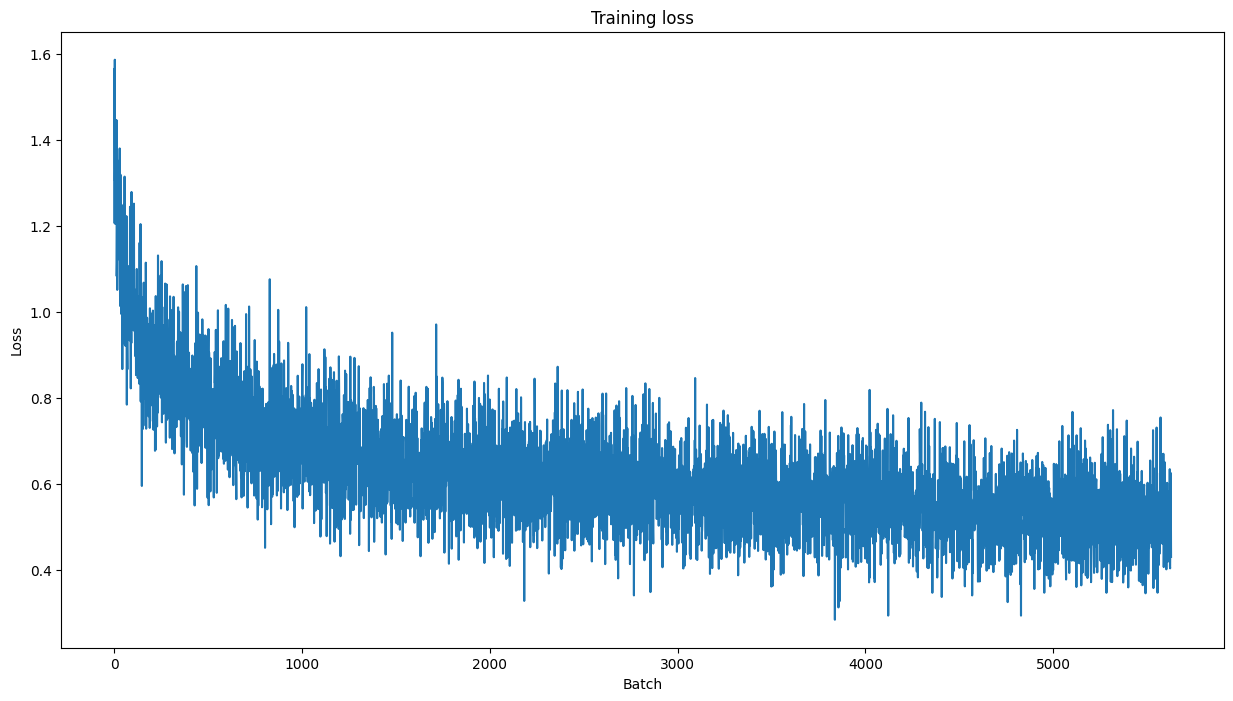

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
finetuned_model = BertForMaskedLM.from_pretrained("./scbert-finetuned").to(device)
finetuned_model.eval()

# Evaluate both on the same validation set
def evaluate_model(model, dataloader):
    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            total_loss += outputs.loss.item()
    return total_loss / len(dataloader)

base_val_loss      = evaluate_model(model,      val_dataloader)
finetuned_val_loss = evaluate_model(finetuned_model, val_dataloader)

print(f"Base model   validation loss: {base_val_loss:.4f}")
print(f"Fine-tuned   validation loss: {finetuned_val_loss:.4f}")

Base model   validation loss: 2.8458
Fine-tuned   validation loss: 0.9721


In [ ]:
import math

base_perplexity = math.exp(base_val_loss)
fine_tuned_perplexity = math.exp(finetuned_val_loss)

print(f"Base model perplexity: {base_perplexity:.4f}")
print(f"Fine-tuned model perplexity: {fine_tuned_perplexity:.4f}")

Base model perplexity: 17.2153
Fine-tuned model perplexity: 2.6434


In [ ]:
from torch.nn.functional import softmax

def top_k_accuracy(model, tokenizer, dataloader, k=5):
    correct = 0
    total = 0
    model.eval()

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        mask_token_mask = input_ids == tokenizer.mask_token_id
        if not mask_token_mask.any(): continue

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        masked_positions = mask_token_mask.nonzero(as_tuple=True)
        masked_logits = logits[masked_positions]
        masked_labels = input_ids[masked_positions]

        topk_preds = masked_logits.topk(k, dim=-1).indices
        correct += (topk_preds == masked_labels.unsqueeze(1)).any(dim=1).sum().item()
        total += masked_labels.size(0)

    return correct / total if total > 0 else None

acc_base = top_k_accuracy(model, tokenizer, val_dataloader, k=5)
acc_finetuned = top_k_accuracy(finetuned_model, tokenizer, val_dataloader, k=5)
print(f"Top-5 Accuracy — Fine-tuned: {acc_finetuned:.3f}, Base: {acc_base:.3f}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Top-5 Accuracy — Fine-tuned: 0.000, Base: 0.000
